In [729]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Загрузка данных, добавление столбца приращения

В качестве данных был выбран курс доллара к евро с интервалом 4 часа.
Open -- курс (сколько долларов стоит 1 евро) на момент начала рассматриваемого часа. Будем работать с этими значениями.
delta -- разница в цене рассматриваемого часа с предыдущим. Из выборки было взято 10000 значений, идущих подряд.

In [730]:
currency_data: pd.DataFrame = pd.read_csv("EURUSD_H1.csv", sep="\t", usecols=["Time", "Open"])
currency_data["delta"] = currency_data["Open"].shift(1) - currency_data["Open"]
currency_data = currency_data.fillna(value=0)

# Перемешаем delta
# currency_data = currency_data.iloc[np.random.permutation(len(currency_data))]

data: np.ndarray = currency_data["delta"][:2000]

# Гистограмма для delta

Гистограмма для распределения delta. Столбец -- число записей, попавших в интервал, число интервалов -- 100. 
Строится автоматически, здесь не было задания строить гистограмму вручную

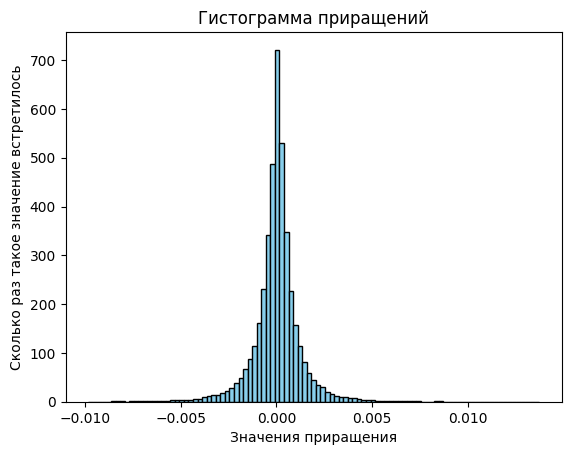

In [731]:
segments_count: int = 100
delta_min: float = np.min(data)
delta_max: float = np.max(data)

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)

plt.hist(currency_data["delta"], bins=intervals, color='skyblue', edgecolor='black', density=True)
# density -- нормировка, чтобы сумма площадей столбцов была равна 1
 
# Adding labels and title
plt.xlabel('Значения приращения')
plt.ylabel('Сколько раз такое значение встретилось')
plt.title('Гистограмма приращений')
 
# Display the plot
plt.show()

Визуально больше всего похоже на распределение Лапласа. Но проверим позднее

# Ядерная оценка плотности

Формула:
$f_n(x) = \frac{1}{nh_n} \sum_{i=1}^{i=n}g(\frac{x-x_i}{h_n})$

$n -число \ интервалов$


$f_n(x) -оценка \ плотности$


$h_n -интервал, \ все \ интервалы \ берутся \ одинаковые \ и \ можно \ использовать \ просто \ h$


$g - плотность \ известной \ функции, g(x) = G^'(x), G(x) - ядро$

В курсе упоминалось, что в качестве G часто берут стандартную нормальную функцию распределения. Ее и используем.

Тогда 

$g(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}$

Теперь посчитаем. Интервалы берем одинаковые, за левую и правую грани -- минимальные и максимальные значения delta, размер интервала задаем числом n.

Вычисляем минимум, максимум и размер интервала по заданному n

In [732]:
segments_count: int = 100
delta_min: float = np.min(data)
delta_max: float = np.max(data)

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)
segment_size: float = (delta_max - delta_min) / segments_count

Функция вычисления плотности стандартного нормального распределения

In [733]:
def std_norm_density(x: float) -> float:
    """Функция плотности стандартного нормального распределения"""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x ** 2))

Вычисление ядерных оценок по формуле выше

In [734]:
kde_values: np.ndarray = np.zeros_like(intervals)
for x in data:
    kde_values += std_norm_density((intervals - x) / segment_size)

kde_values /= (segment_size * len(data))


График полученной плотности и график delta

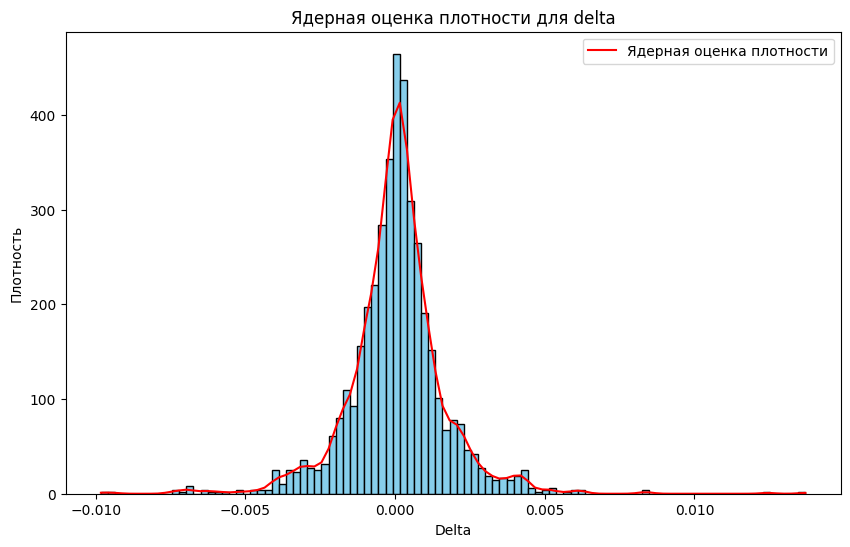

In [735]:
# Построение графика
segments_count: int = 100
delta_min: float = np.min(data)
delta_max: float = np.max(data)

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)

plt.figure(figsize=(10, 6))
plt.plot(intervals, kde_values, color="red", label='Ядерная оценка плотности')
plt.hist(data, bins=intervals, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Delta')
plt.ylabel('Плотность')
plt.title('Ядерная оценка плотности для delta')
plt.legend()
plt.show()

Чем меньше интервалов, тем плавнее график. Чем их больше, тем больше он похож на гистограмму со слишком большим числом сегментов (что логично, в общем-то)

# Метод максимального правдоподобия

Метод максимального правдоподобия предполагает вычислить и максимизировать значение функции правдоподобия для выборки.

### Нормальное распределение

В курсе проходили оценку ММП для нормального распределения:
$$N(\alpha, \sigma^2), \[f(x|\alpha, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \alpha)^2}{2\sigma^2}\right). \]$$

Оценки: 
$$\[\hat{\alpha} = \frac{1}{n} \sum_{i=1}^{n} x_i. \]$$
$$\[\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{\alpha})^2.\]$$


Оценка методом максимального правдоподобия (ММП) для параметров нормального распределения и распределения Лапласа основана на максимизации функции правдоподобия.

### Распределение Лапласа
Для распределения Лапласа оценка методом ММП дает следующие результаты:
$$\[ f(x|\alpha, b) = \frac{1}{2b} \exp\left(-\frac{|x - \alpha|}{b}\right). \]$$

$$\[ \hat{\alpha} = \text{median}(x_1, x_2, \ldots, x_n). \]$$


$$\[ \hat{b} = \frac{1}{n} \sum_{i=1}^{n} |x_i - \hat{\alpha}|. \]$$

Теперь оценим:

In [736]:
a_norm: float = np.mean(data)
sigma_squared_norm: float = np.var(data)
sigma_norm: float = np.sqrt(sigma_squared_norm)

a_laplace: float = np.median(data)
b_laplace: float = np.sum(abs(data - a_laplace)) / len(data)

print(a_norm, sigma_squared_norm)
print(a_laplace, b_laplace)

4.900500000000008e-05 2.705957059974991e-06
7.00000000000145e-05 0.0010935550000000013


## Графики построенных распределений:

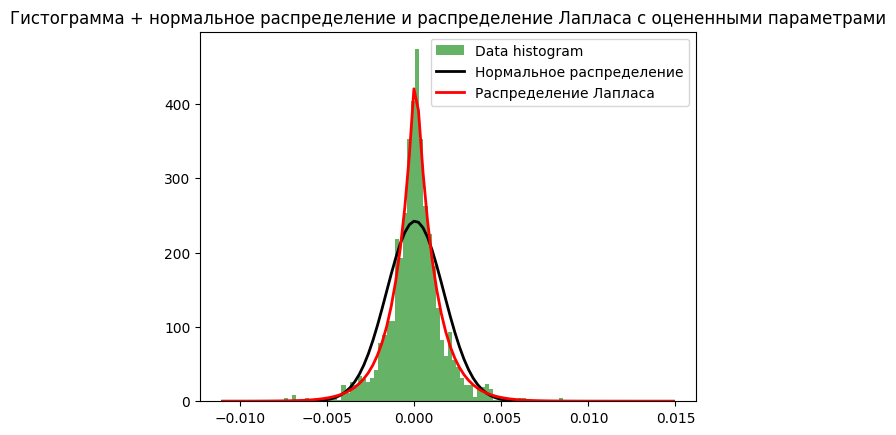

In [737]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Генерация случайного массива данных
np.random.seed(0)

# Параметры нормального и Лапласовского распределений
mu_norm, sigma_norm = a_norm, sigma_norm
mu_laplace, b_laplace = a_laplace, b_laplace

# Создание гистограммы
plt.hist(data, bins=100, density=True, alpha=0.6, color='g', label='Data histogram')

# Нормальное распределение
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_norm = stats.norm.pdf(x, mu_norm, sigma_norm)
plt.plot(x, p_norm, 'k', linewidth=2, label='Нормальное распределение')

# Распределение Лапласа
p_laplace = stats.laplace.pdf(x, mu_laplace, b_laplace)
plt.plot(x, p_laplace, 'r', linewidth=2, label='Распределение Лапласа')

# Добавление легенды
plt.legend(loc='upper right')

# Отображение графика
plt.title('Гистограмма + нормальное распределение и распределение Лапласа с оцененными параметрами')
plt.show()

In [738]:
from scipy.integrate import quad
from typing import Callable

def normal_density(x, a=0, sigma=1):
    """Плотность нормального распределения"""
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - a) / sigma) ** 2)

def laplace_density(x, a=0, b=0):
    return np.exp(-1 * np.abs(x-a) / b) / (2 * b)


def p_interval(left: float, right: float, density_func: Callable) -> float:
    """Вероятность попасть в заданный интервал"""
    p, err = quad(func=density_func, a=left, b=right)
    return p

Normal: 2749922.094543395
Laplace: 36.023161144297674
Expected: 33.40866360500462
SciPy Normal: Power_divergenceResult(statistic=2749922.094543395, pvalue=0.0)
SciPy Laplace: Power_divergenceResult(statistic=36.02316114429767, pvalue=0.01048660646436205)


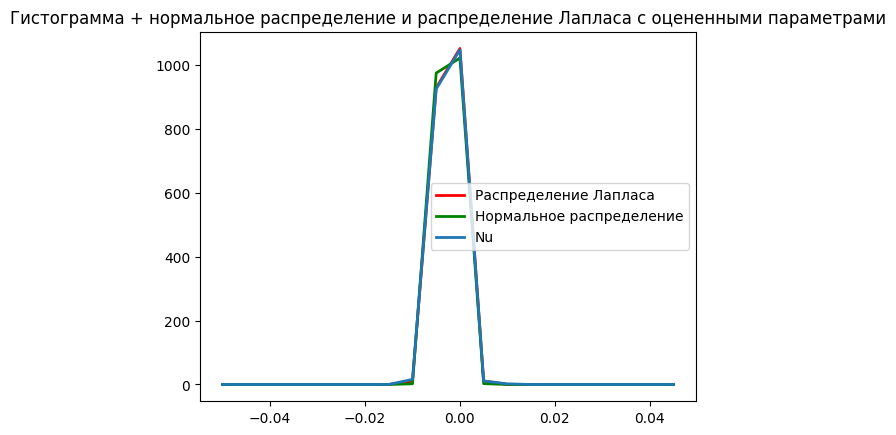

In [764]:
import scipy.stats as stats
from functools import partial

# Разбиение на сегменты
segments_count: int = 20
borders_count: int = segments_count + 1

delta_min: float = -1/20
delta_max: float = 1/20

# TODO: а можно ли так вообще делать?
# delta_min, delta_max = np.min(data) - 1/100, np.max(data) + 1/100

intervals: np.ndarray = np.linspace(delta_min, delta_max, borders_count)

# Вычисление числа элементов в этих сегментах (nu_i в формуле)
nu: np.ndarray = np.zeros(segments_count, dtype=int)
for i in range(segments_count):
    for elem in data:
        if intervals[i] < elem <= intervals[i + 1]:
            nu[i] += 1               
                
# Вычисление вероятностей попасть в интервал (p_i в формуле) 
p_norm: np.ndarray = np.zeros(segments_count, dtype=float)
for i in range(segments_count):
    p_norm[i] = p_interval(right=intervals[i + 1], left=intervals[i], density_func=partial(normal_density, a=a_norm, sigma=sigma_norm))
    
p_laplace: np.ndarray = np.zeros(segments_count, dtype=float)
for i in range(segments_count):
    p_laplace[i] = p_interval(right=intervals[i + 1], left=intervals[i], density_func=partial(laplace_density, a=a_laplace, b=b_laplace))
    
chi_squared_norm: float = np.sum((nu - p_norm * len(data)) ** 2 / p_norm) / len(data)
chi_squared_laplace: float = np.sum((nu - p_laplace * len(data)) ** 2 / p_laplace) / len(data)
 
print("Normal:", chi_squared_norm)
print("Laplace:", chi_squared_laplace)

alpha = 0.01
# TODO: какое число степеней свободы все-таки?
print("Expected:", stats.chi2.ppf(1 - alpha, df=segments_count - 2 - 1))

print("SciPy Normal:", stats.chisquare(f_obs=nu, f_exp=p_norm * len(data)))
print("SciPy Laplace:", stats.chisquare(f_obs=nu, f_exp=p_laplace * len(data)))

plt.plot(intervals[:-1], p_laplace * len(data), 'r', linewidth=2, label='Распределение Лапласа')
plt.plot(intervals[:-1], p_norm * len(data), 'g', linewidth=2, label='Нормальное распределение')
plt.plot(intervals[:-1], nu, linewidth=2, label='Nu')

# Добавление легенды
plt.legend(loc='center right')

# Отображение графика
plt.title('Гистограмма + нормальное распределение и распределение Лапласа с оцененными параметрами')
plt.show()

## Проверка гипотезы критерием хи-квадрат
$$\[\nu_i = \sum_{i=1}^n I(X_j \in \delta_i)\]$$
$$p_i = P(X_j \in \delta_i), X_j - НОРСВ$$
$$\[\chi^2 = \sum_{i=1}^k \frac{(\nu_i - np_i)^2}{np_i}\]$$
   

Критерий Пирсона доказан только для интервалов, не зависящих от выборки. Так что возьмем разбиение на N сегментов на интервале, "на глаз" покрывающем выборку. $P_i$ -- вероятность попасть в i-й интервал. 

Визуально нормальное распределение не похоже, а вот распределение Лапласа -- более-менее

Вычисление хи-квадрата. Расписать с планшета, тут не хватает.

# Дополнение: вычисление ММП для нормального распределения
Для начала вычислим математическое ожидание (a) и дисперсию ($\sigma^2$) методом максимального правдоподобия.

Если $\( X_1, X_2, \ldots, X_n \)$ — независимые одинаково распределенные случайные величины с нормальным распределением $\( N(a, \sigma^2) \)$, то функция правдоподобия для этих данных определяется как произведение плотностей вероятности для каждого наблюдения:

$\[L(a, \sigma^2 \mid X_1, X_2, \ldots, X_n) = \prod_{i=1}^n f(X_i \mid a, \sigma^2)\]$

где $\( f(X_i \mid a, \sigma^2) \)$ — плотность нормального распределения:

$\[f(X_i \mid a, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(X_i - a)^2}{2\sigma^2} \right)\]$

Таким образом, функция правдоподобия имеет вид:

$\[L(a, \sigma^2) = \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)^n \exp\left( -\sum_{i=1}^n \frac{(X_i - a)^2}{2\sigma^2} \right)\]$

Логарифм функции правдоподобия (логарифмическая функция правдоподобия) удобнее максимизировать:

$\[\ln L(a, \sigma^2) = -\frac{n}{2} \ln (2\pi) - \frac{n}{2} \ln (\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (X_i - a)^2\]$


Для максимизации логарифмической функции правдоподобия нужно взять производные по \(a\) и \(\sigma^2\) и приравнять их к нулю.

**Для a**:
$\[\frac{\partial \ln L}{\partial a} = \frac{1}{\sigma^2} \sum_{i=1}^n (X_i - a) = 0\]$

Решая это уравнение, получаем оценку для \(a\):

$\[\hat{a} = \frac{1}{n} \sum_{i=1}^n X_i\]$

**Для $\(\sigma^2\)$**:

$\[\frac{\partial \ln L}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^n (X_i - a)^2 = 0\]$

Решая это уравнение, получаем оценку для $\(\sigma^2\)$:

$\[\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (X_i - \hat{a})^2\]$

То есть получили стандартные формулы для математического ожидания и дисперсии выборки. Считать их будем через стандартные методы библиотеки. Метод моментов для нормального распределения даст те же формулы.
